Image classifier for team ornithomimus.
---
Here's the basics of this model: 

The purpose of this classifier is to predict if a user will like or dislike a specific image. To do this, we build up a dataset of images that the user has marked as liked or disliked while swiping on the app. Any image that the user has seen is used in the training dataset, and we will send images the user has not seen to the model when making predictions.

The dataset starts with all images unrated. When a user likes or dislikes a hike, the hike name and user rating is sent from the app to this image classifier. The matching photo is then moved from the unrated folder to either the like or dislike folder. After a number of images are in the two rated folders, the training dataset can be recompiled and used to train the model.

In order to select which photos to send back to the user, we can give a photo name to the model from a list of possible hikes. The model will then predict if the hike will be liked or disliked; photos that the model predicts will be disliked are discarded, and the rest can be sent to the user.

In [ ]:
# Imports
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import pdb
from PIL import Image
import shutil

Image Classifier Steps:
---
1. Recieve ratings from user, parse information
2. Based on ratings, move appropriate photos from testing dataset into training dataset, labelled with rating
3. Train model using updated dataset
4. Give model new, unrated photos to get recommended photos, do something with the output


___
Here's the current plan:

For isolated testing we will use a small dataset in 2 main folders. The first folder contains the training data, and has two subfolders: likes and dislikes. The third folder will contain images that have not been rated yet, and will be used for testing.

When the user rates an image, the photo they rated will be moved from the testing folder to the appropriate training folder. At this time, the dataset will be recompiled using the new photos. Since the number of rated photos is relatively small compared to the number of unrated photos, rebuilding the dataset does not take much time.

In [ ]:
# For testing, upload 291_test_dataset.zip to your notebook and unzip it
# The test dataset can be found in reports/M2/image-classifier
!unzip 291_test_dataset.zip

Here is a proof of concept for moving photos around in the datasets. This function takes the name of an image and its labelled rating as input, and moves it to the appropriate folder for the training dataset.

In [ ]:
# Takes the name of an image as a string, moves the image to the appropriate folder

def label_image(img_name,label):
    source_dir = "291_test_dataset/unrated"
    if not(os.path.isfile(f"{source_dir}/{img_name}.jpg")):
        print("Image not found")
        return
    
    if label == 1: # Image is liked
        target_dir = "291_test_dataset/full_dataset/likes"
    else: # Image is disliked
        target_dir = "291_test_dataset/full_dataset/dislikes"
    
    shutil.move(f"{source_dir}/{img_name}.jpg", target_dir)

To increase the effective size of our dataset, we are using as much data augmentation as practical. Since our images are generally of landscapes, transforms such as rotation, vertical flips, and large crops are unrealistic. Instead, we are using horizontal flips, random gaussian blur, and random color manipulation. All of the augmentations are subtle, and could conceivably be used by people posting images on social media.

In [ ]:
xform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ColorJitter(brightness=0.1,contrast=0.3,saturation=0.2),
                            transforms.GaussianBlur(kernel_size=5),
                            transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('291_test_dataset/full_dataset', transform=xform)

In [ ]:
# Simple convenience function for printing a number of samples from each dataset
def print_dataset_samples(num_samples=10, dataset="train"):
    for i in range(num_samples):
        if dataset == "train":
            img = dataset_train[i]
        elif dataset == "test":
            img = dataset_test[i]
        else:
            img = dataset_full[i]
        plt.imshow(img[0].permute(1,2,0))
        print(dataset_full.classes[img[1]])
        plt.show()

dislikes


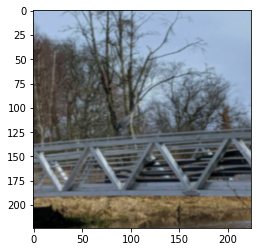

dislikes


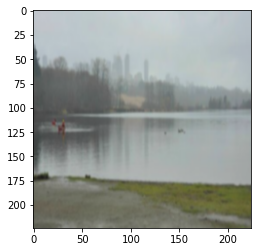

In [ ]:
print_dataset_samples(2, "full")

In our full implementation, we want to use all of the available images for training. While testing, however, it is useful to have some photos available to verify that the model is making reasonable predictions. So for now, we'll split the dataset into training and testing datasets.

In [ ]:
n_all = len(dataset_full)
n_train = int(0.6 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(3621)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)
print(len(dataset_test), len(dataset_train))

20 28


In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

Making the model
---
Since our dataset is so small, there is little point in having a complex model. So, our goal is to have a model that is "good enough" while being as fast as possible. We tested a few candidates for use as a pretrained model, and found that of DenseNet, ResNet, MobileNet, and VGG-16, ResNet-18 seems to be the best candidate. Running on a cpu, ResNet was about 5 times faster than the other 4 options, while providing comparable accuracy.

The main challenge now is to figure out how to reduce overfitting. Since the dataset size is determined by the number of swipes the user has done, it starts at 0 images and grows linearly. As such, it is very easy for the model to overtrain and memorize the few dozen photos it has. To reduce the chance of overfitting, we will use plenty of data augmentation, as well as dropout.

In [ ]:
# Create a model using ResNet
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(p=0.2),
                         nn.Linear(model.fc.in_features, 2))
torch.nn.init.xavier_uniform_(model.fc[1].weight)

Parameter containing:
tensor([[ 0.0664,  0.0976,  0.0753,  ..., -0.0358, -0.0840,  0.0667],
        [ 0.0368, -0.0693,  0.0653,  ...,  0.1052,  0.0185,  0.0894]],
       requires_grad=True)

In [ ]:
device = torch.device('cpu')
model = model.to(device)

Our model is currently set up as a simple binary classifier with standard parameters. More testing is required to find the best parameters, but again, the model simply needs to be good enough without being too slow. 

A few notable points: We have momentum set to 0, since the dataset is constantly updating. It makes no sense for older photos to have a greater impact than new ones, so this parameter reflects this.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

These definitions have been taken directly from my (Andrew's) assignment 2. 

In [ ]:
def run_train(model, opt, sched):
  nsamples_train = len(dataset_train)
  loss_sofar, correct_sofar = 0, 0
  model.train()
  with torch.enable_grad():
    for samples, labels in loader_train:
      samples = samples.to(device)
      labels = labels.to(device)
      opt.zero_grad()
      outs = model(samples)
      _, preds = torch.max(outs.detach(), 1)
      loss = criterion(outs, labels)
      loss.backward()
      opt.step()
      loss_sofar += loss.item() * samples.size(0)
      correct_sofar += torch.sum(preds == labels.detach())
  sched.step()
  return loss_sofar / nsamples_train, correct_sofar / nsamples_train

def run_test(model):
  n_test = len(dataset_test)
  loss, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for samples, labels in loader_test:
      samples = samples.to(device)
      labels = labels.to(device)
      outs = model(samples)
      loss += criterion(outs, labels)
      _, preds = torch.max(outs.detach(), 1)
      correct_mask = preds == labels
      correct += correct_mask.sum(0).item()
  return loss / n_test, correct / n_test

def run_all(model, optimizer, scheduler, n_epochs):
  for epoch in range(n_epochs):
    loss_train, acc_train = run_train(model, optimizer, scheduler)
    loss_test, acc_test = run_test(model)
    print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

In [ ]:
run_all(model, optimizer, scheduler, 10)

epoch 0: train loss 0.1639 acc 0.9286, test loss 0.2796 acc 0.6000
epoch 1: train loss 0.0546 acc 0.9643, test loss 0.3015 acc 0.6000
epoch 2: train loss 0.1838 acc 0.9286, test loss 0.2257 acc 0.6500
epoch 3: train loss 0.1185 acc 0.8929, test loss 0.3387 acc 0.5500
epoch 4: train loss 0.0294 acc 1.0000, test loss 0.3351 acc 0.5000
epoch 5: train loss 0.3517 acc 0.8571, test loss 0.2421 acc 0.6000
epoch 6: train loss 0.4308 acc 0.8571, test loss 0.3226 acc 0.5500
epoch 7: train loss 0.1276 acc 0.9286, test loss 0.3295 acc 0.5500
epoch 8: train loss 0.0171 acc 1.0000, test loss 0.3394 acc 0.5000
epoch 9: train loss 0.3037 acc 0.8929, test loss 0.2527 acc 0.7000


Up next are functions for working with single, unrated images. First, `classify_images` takes the name of an image in the unrated folder and predicts if it is a like or a dislike. This will be used to make predictions on which items to recommend to the user.

`print_unrated_image` is a convenience function for displaying an unrated image alongside its predicted rating.

In [ ]:
# Given a single image in the unrated folder, predict how the user will rate it
def classify_image(model, img_name):
    # Find the image in the folder and prepare it for the model
    img_path = '291_test_dataset/unrated/' + img_name + '.jpg'
    try:
        pil_img = Image.open(img_path).convert('RGB')
    except:
        # If image cannot be found, return 0 for dislike
        print("Image not found")
        return 0
    img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img = img_transform(pil_img) # Transform image

    model.eval()
    with torch.no_grad():
        img = img.to(device).unsqueeze(0) # Add a dimention so the model can use it
        out = model(img)
        _, pred = torch.max(out.detach(), 1)
    return pred.item()

# Convenience function for displaying an unrated image with its predicted rating
def print_unrated_image(img_name):
    img_path = '291_test_dataset/unrated/' + img_name + '.jpg'
    try:
        pil_img = Image.open(img_path).convert('RGB')
    except:
        # If image cannot be found, return 0 for dislike
        print("Image not found")
        return 0
    img_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    img = img_transform(pil_img) # Transform image
    plt.imshow(img.permute(1,2,0))
    print("Predicted class:", dataset_full.classes[classify_image(model, img_name)])

Predicted class: dislikes


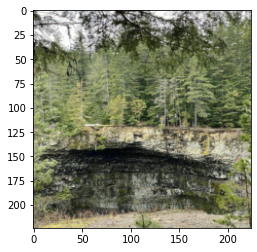

In [ ]:
print_unrated_image("brandywine-trail-1")